# Exemplificare probleme de clasificare 

Se doreste identificarea tipului de tesut mamar pe baza unor masuratori bioelectrice (e.g. I0  - impedanta la frecventa 0, MaxIP - spectrul maxim, Area - Aria de sub spectru, etc.)




## setup preparation

In [1]:
#@title run the code below for prerequisites

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn import tree
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

import csv
import matplotlib.pyplot as plt 
import os
import io
import requests
import pandas as pd


def loadData(fileName, featureNames, outputVariabName):
    data = []
    dataNames = []
    csv_reader = csv.reader(fileName, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            dataNames = row
        else:
            data.append(row)
        line_count += 1
    inputs = []
    for i in range(len(data)):
        crtExample = []
        for feature in featureNames:
            selectedVariable = dataNames.index(feature)
            crtExample.append(data[i][selectedVariable])
        inputs.append(crtExample)
        
    selectedOutput = dataNames.index(outputVariabName)
    outputs = []
    for i in range(len(data)):
        outputs.append(data[i][selectedOutput])
    
    return inputs, outputs


def fromStringToNumericData(values):
    if isinstance(values[0], list):
        aux = []
        for i in range(len(values)):
            line = []
            for j in range(len(values[i])):
                line.append(float(values[i][j]))
            aux.append(line)
        return aux
    else:
        aux = []
        for i in range(len(values)):
            aux.append(float(values[i]))
        return aux

def getFeature(data, pos):
    values = []
    for i in range(len(data)):
        values.append(data[i][pos])
    return values

def plotHistograms(inputs, outputs):
    noFeatures = len(inputs[0])
    fig, ax = plt.subplots(1, noFeatures + 1,  figsize=(4 * (noFeatures + 1), 4))
    for i in range(noFeatures):
        crtFeatureValues = getFeature(inputs, i)
        ax[i].hist(crtFeatureValues, 10, color = 'r')
        ax[i].title.set_text('histogram of ' + featureNames[i])
    ax[noFeatures].hist(outputs, 10, color = 'g')
    ax[noFeatures].title.set_text('histogram of ' + outputName)

    plt.show()


def plotClassificationData(inputs, outputs, featureNames):
    noExamples = len(inputs)
    labels = set(outputs)
    noData = len(inputs)
    for crtLabel in labels:
        x = [inputs[i][0] for i in range(noExamples) if outputs[i] == crtLabel ]
        y = [inputs[i][1] for i in range(noExamples) if outputs[i] == crtLabel ]
        plt.scatter(x, y, label = crtLabel)
    plt.xlabel(featureNames[0])
    plt.ylabel(featureNames[1])
    plt.legend()
    plt.show()  


def plotPredictions(feature1, feature2, realOutputs, computedOutputs, title, featureNames, labels):
    noData = len(feature1)
    for crtLabel in labels:
        x = [feature1[i] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] == crtLabel ]
        y = [feature2[i] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] == crtLabel]
        plt.scatter(x, y, label = crtLabel + ' (correct)')
    for crtLabel in labels:
        x = [feature1[i] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] != crtLabel ]
        y = [feature2[i] for i in range(noData) if realOutputs[i] == crtLabel and computedOutputs[i] != crtLabel]
        plt.scatter(x, y, label = crtLabel + ' (incorrect)')
    plt.xlabel(featureNames[0])
    plt.ylabel(featureNames[1])
    plt.legend()
    plt.title(title)
    plt.show()
       
def plotADecisionTree(clf):
  n_nodes = clf.tree_.node_count
  children_left = clf.tree_.children_left
  children_right = clf.tree_.children_right
  feature = clf.tree_.feature
  threshold = clf.tree_.threshold

  node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
  is_leaves = np.zeros(shape=n_nodes, dtype=bool)
  stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
  while len(stack) > 0:
      # `pop` ensures each node is only visited once
      node_id, depth = stack.pop()
      node_depth[node_id] = depth

      # If the left and right child of a node is not the same we have a split
      # node
      is_split_node = children_left[node_id] != children_right[node_id]
      # If a split node, append left and right children and depth to `stack`
      # so we can loop through them
      if is_split_node:
          stack.append((children_left[node_id], depth + 1))
          stack.append((children_right[node_id], depth + 1))
      else:
          is_leaves[node_id] = True

  # print("The binary tree structure has {n} nodes and has "
  #       "the following tree structure:\n".format(n=n_nodes))
  # for i in range(n_nodes):
  #     if is_leaves[i]:
  #         print("{space}node={node} is a leaf node.".format(
  #             space=node_depth[i] * "\t", node=i))
  #     else:
  #         print("{space}node={node} is a split node: "
  #               "go to node {left} if X[:, {feature}] <= {threshold} "
  #               "else to node {right}.".format(
  #                   space=node_depth[i] * "\t",
  #                   node=i,
  #                   left=children_left[i],
  #                   feature=feature[i],
  #                   threshold=threshold[i],
  #                   right=children_right[i]))
          
  tree.plot_tree(clf)
  plt.show()


print("setup is ready...")

setup is ready...


## Scenariul 1: predictia tipului de tesut (normal sau patologic) pe baza caracteristicilor MaxIP si Area

Proces:
- Se pleaca de la un set de date format din masuratorile bioelectrice asociate unor probe de tesut mamar  si etichetele asociate lor
- se aleg anumite caracteristici dintre aceste masuratori (drept variabile independente) precum MaxIP si Area
- Se aplica algoritmul de invatare pe setul de antrenament
- Se realizeaza predictii pentru noi mesaje (= se eticheteaza noi mesaje)

In [2]:
#@title run the code below to inspect the raw data

import requests
import io
import pandas as pd

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/breastCancerBin.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

dataCrt = pd.read_csv(filePath)
dataCrt.head()

,Case#,Class,I0,PA500,HFS,DA,Area,A/DA,MaxIP,DR,P
0,1,pathological,524.794072,0.187448,0.032114,228.800228,6843.598481,29.910803,60.204880,220.737212,556.828334
1,2,pathological,330.000000,0.226893,0.265290,121.154201,3163.239472,26.109202,69.717361,99.084964,400.225776
2,3,pathological,551.879287,0.232478,0.063530,264.804935,11888.391830,44.894903,77.793297,253.785300,656.769449
3,4,pathological,380.000000,0.240855,0.286234,137.640111,5402.171180,39.248524,88.758446,105.198568,493.701814
4,5,pathological,362.831266,0.200713,0.244346,124.912559,3290.462446,26.342127,69.389389,103.866552,424.796503


### Specificarea problemei
- stabilirea caracteristicilor (date de intrare) - MaxIP si Area
- stabilirea valorilor care trebuie prezise (date de iesire) - tipul de tesut (normal sau patologic)

In [3]:
#@title run the code below for setting the input data and the output data
# first use case: predict the type of tissue (connective, adipose, glandular, carcinoma, fibro-adenoma, mastopathy) based on MaxIP and Area
noFeatures = 2
featureNames = ['MaxIP', 'Area']
outputName = 'Class'

### Incarcarea si auditarea datelor

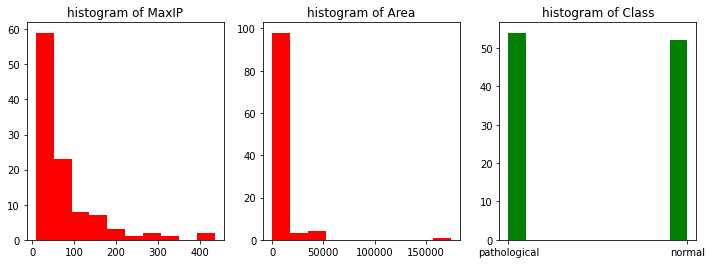

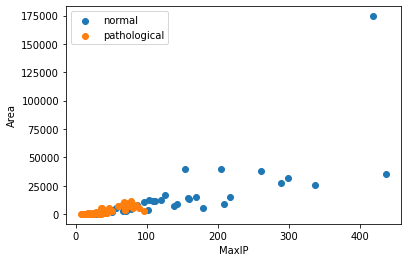

In [4]:
#@title run the code below for loading and auditing the data

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/breastCancerBin.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)


inputs, outputs = loadData(filePath, featureNames, outputName)
inputs = fromStringToNumericData(inputs)

# audit the data
plotHistograms(inputs, outputs)
if (noFeatures == 2):
    plotClassificationData(inputs, outputs, featureNames)

### Antrenarea unui model de predictie

In [5]:
#@title run the code below for training the classifier; the training error will be printed
classifier1 = linear_model.LogisticRegression()
classifier1.fit(inputs, outputs)
computedOutputs = classifier1.predict(inputs)
error = 1 - accuracy_score(outputs, computedOutputs)
print("classification training error: ", error)

classification training error:  0.30188679245283023


### Utilizarea unui model de predictie

In [6]:
#@title run the code below from preparing sone testing data

# normal, pathological, normal
testData = [[59.5, 280.5], [61, 3039.5], [60, 305]]

computed labels:  ['normal' 'normal' 'normal']


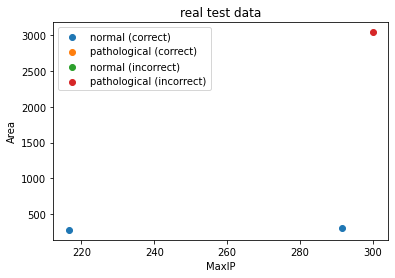

In [7]:
#@title run the code below for predicting the tissue type for previous prepared data

predictions = classifier1.predict(testData)
print('computed labels: ', predictions)

if (noFeatures == 2):
    plotPredictions([216.5, 300, 291.5], [280.5, 3039.5, 305], ['normal', 'pathological', 'normal'], predictions, "real test data", featureNames, ['normal', 'pathological'])

## Scenariul 2: predictia tipului de tesut (normal sau patologic) pe baza caracteristicilor I0 si Area


Proces:
- Se pleaca de la un set de date format din masuratorile bioelectrice asociate unor probe de tesut mamar  si etichetele asociate lor
- se aleg anumite caracteristici dintre aceste masuratori (drept variabile independente) precum IO si Area
- Se aplica algoritmul de invatare pe setul de antrenament
- Se realizeaza predictii pentru noi mesaje (= se eticheteaza noi mesaje)

In [8]:
#@title run the code below to inspect the raw data

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/breastCancerBin.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

dataCrt = pd.read_csv(filePath)
dataCrt.head()

,Case#,Class,I0,PA500,HFS,DA,Area,A/DA,MaxIP,DR,P
0,1,pathological,524.794072,0.187448,0.032114,228.800228,6843.598481,29.910803,60.204880,220.737212,556.828334
1,2,pathological,330.000000,0.226893,0.265290,121.154201,3163.239472,26.109202,69.717361,99.084964,400.225776
2,3,pathological,551.879287,0.232478,0.063530,264.804935,11888.391830,44.894903,77.793297,253.785300,656.769449
3,4,pathological,380.000000,0.240855,0.286234,137.640111,5402.171180,39.248524,88.758446,105.198568,493.701814
4,5,pathological,362.831266,0.200713,0.244346,124.912559,3290.462446,26.342127,69.389389,103.866552,424.796503


### Specificarea problemei
- stabilirea caracteristicilor (date de intrare) - I0 si Area
- stabilirea valorilor care trebuie prezise (date de iesire) - Class

In [9]:
#@title run the code below for setting the input data and the output data
# second use case: predict the type of tissue (connective, adipose, glandular, carcinoma, fibro-adenoma, mastopathy) based on I0 and Area
noFeatures = 2
featureNames = ['I0', 'Area']
outputName = 'Class'

### Incarcarea si auditarea datelor

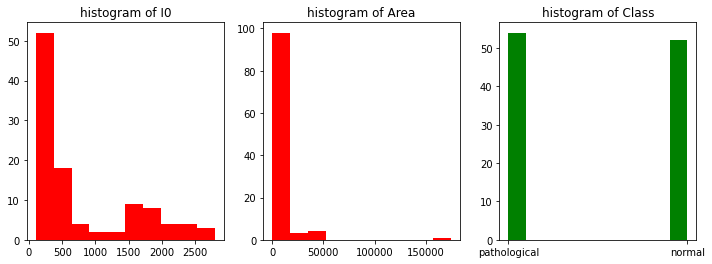

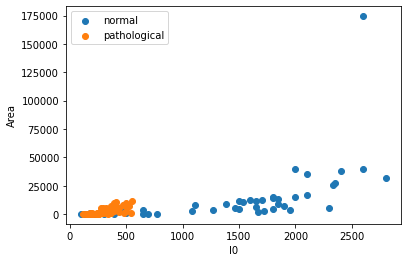

In [10]:
#@title run the code below for loading and auditing the data

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/breastCancerBin.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

inputs, outputs = loadData(filePath, featureNames, outputName)
inputs = fromStringToNumericData(inputs)

# audit the data
plotHistograms(inputs, outputs)
if (noFeatures == 2):
    plotClassificationData(inputs, outputs, featureNames)

### Antrenarea unui model de predictie

In [11]:
#@title run the code below for training the classifier; the training error will be printed

classifier2 = linear_model.LogisticRegression()
classifier2.fit(inputs, outputs)
computedOutputs = classifier2.predict(inputs)
error = 1 - accuracy_score(outputs, computedOutputs)
print("classification training error: ", error)


classification training error:  0.15094339622641506


### Utilizarea unui model de predictie

In [12]:
#@title run the code below from preparing sone testing data

# realLabels= [normal, pathological, normal]
testData = [[216.5, 280.5], [300, 3039.5], [291.5, 305]]



computed labels:  ['pathological' 'pathological' 'pathological']


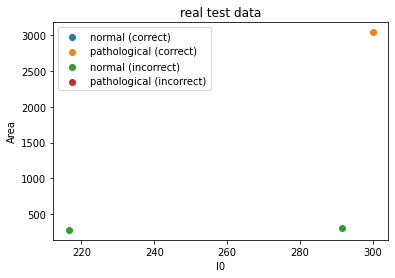

In [13]:
#@title run the code below for predicting the tissue type for previous prepared data

predictions = classifier2.predict(testData)
print('computed labels: ', predictions)

if (noFeatures == 2):
    plotPredictions([216.5, 300, 291.5], [280.5, 3039.5, 305], ['normal', 'pathological', 'normal'], predictions, "real test data", featureNames, ['normal', 'pathological'])
    

## Scenariul 3: predictia tipului de tesut (normal sau patologic, dar de 3 tipuri) pe baza caracteristicilor I0 si Area


Proces:
- Se pleaca de la un set de date format din masuratorile bioelectrice asociate unor probe de tesut mamar  si etichetele asociate lor
- se aleg anumite caracteristici dintre aceste masuratori (drept variabile independente) precum IO si Area
- Se aplica algoritmul de invatare pe setul de antrenament
- Se realizeaza predictii pentru noi mesaje (= se eticheteaza noi mesaje)

In [14]:
#@title run the code below to inspect the raw data

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/breastCancer4classes.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

dataCrt = pd.read_csv(filePath)
dataCrt[18:55]

,Case#,Class,I0,PA500,HFS,DA,Area,A/DA,MaxIP,DR,P
18,19,car,325.000000,0.224624,0.286932,229.215863,5705.332090,24.890651,35.602715,227.264794,462.703007
19,20,car,294.474846,0.206647,0.467748,194.871035,5541.256126,28.435504,36.765797,191.804890,445.513299
20,21,car,500.000000,0.192684,0.194779,144.688578,3055.012963,21.114403,96.563370,107.751103,542.897089
21,22,fad,211.000000,0.053931,0.094248,30.753443,151.984578,4.942034,14.268374,27.243124,217.130704
22,23,fad,196.856714,0.020071,0.090757,28.593126,82.058889,2.869882,7.968783,27.661516,200.749336
23,24,fad,245.000000,0.189019,0.081681,62.902955,1235.983356,19.649051,42.152016,46.690355,292.376238
24,25,fad,352.656447,0.121999,0.090757,68.527846,1066.157846,15.558024,43.691925,52.792817,382.733186
25,26,fad,243.293976,0.039968,0.067021,68.544778,383.928453,5.601134,9.991348,67.816656,263.640761
26,27,fad,259.885145,0.070686,0.006981,58.243807,465.087265,7.985180,17.506838,56.340241,267.517446
27,28,fad,250.000000,0.068068,-0.015359,57.172431,652.901349,11.419863,17.776981,55.791270,278.308615


### Specificarea problemei
- stabilirea caracteristicilor (date de intrare) - I0 si Area
- stabilirea valorilor care trebuie prezise (date de iesire) - Class (car(carcinoma), fad (fibro-adenoma), mas (mastopathy), normal)

In [15]:
#@title run the code below to see the possible labels

print(set(dataCrt['Class']))

{'normal', 'fad', 'mas', 'car'}


In [16]:
#@title run the code below for setting the input data and the output data

# third use case: predict the type of tissue (normal, carcinoma, fibro-adenoma, mastopathy) based on I0 and Area
noFeatures = 2
featureNames = ['I0', 'Area']
outputName = 'Class'

### Incarcarea si auditarea datelor

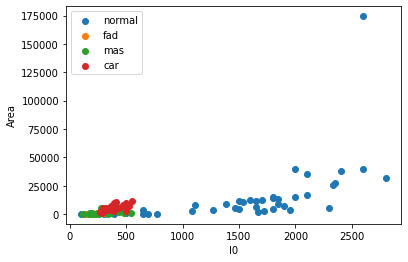

In [17]:
#@title run the code below for loading and auditing the data

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/breastCancer4classes.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

# second use case: predict the type of tissue (normal, carcinoma, fibro-adenoma, mastopathy) based on I0 and Area

inputs, outputs = loadData(filePath, featureNames, outputName)
inputs = fromStringToNumericData(inputs)

# audit the data
if (noFeatures == 2):
    plotClassificationData(inputs, outputs, featureNames)

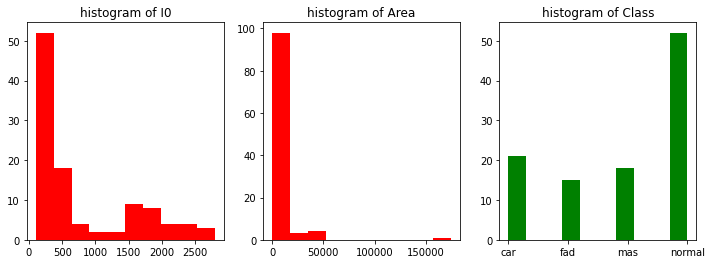

no of exampels:  106  distributed as follows:  {'car': 21, 'fad': 15, 'mas': 18, 'normal': 52}


In [18]:
#@title run the code below for a better description of the data


def countExamples(outputs):
    labels = list(set(outputs)).sort()
    distribution = {}
    for label in outputs:
        if label in distribution.keys():
            distribution[label] += 1
        else:
            distribution[label] = 1
    return distribution

# Cate exemple sunt din fiecare clasa (normal, carcinoma, fibro-adenoma, mastopathy)?
plotHistograms(inputs, outputs)
print('no of exampels: ', len(inputs), ' distributed as follows: ', countExamples(outputs))

### Antrenarea unui model de predictie

In [19]:
#@title run the code below for training the classifier; the training error will be printed

classifier3 = linear_model.LogisticRegression()
classifier3.fit(inputs, outputs)
computedOutputs = classifier3.predict(inputs)
error = 1 - accuracy_score(outputs, computedOutputs)
print("classification training error: ", error)


classification training error:  0.4339622641509434


### Utilizarea unui model de predictie

In [20]:
#@title run the code below from preparing sone (artificial) testing data

# realLabels= [normal, pathological, normal]
testData = [[59.5, 280.5], [61, 3039.5], [60, 305]]

In [21]:
#@title run the code below for predicting the tissue type for previous prepared data

predictions = classifier3.predict(testData)
print('computed labels: ', predictions)

computed labels:  ['mas' 'car' 'mas']


## Scenariul 4 - recunoasterea emotilor in imagini


Proces:
- Se pleaca de la un set de date format din imagini cu fete umane
- Se extrag anumite caracteristici din aceste imagini
- Se aplica algoritmul de invatare pe setul de antrenament
- Se realizeaza predictii pentru noi imagini (= se eticheteaza noi fete cu emotiile corespunzatoare)

### Specificarea problemei

- date de intrare: imagini cu fete
- date de iesire: emotiile asociate fetelor

In [22]:
#@title run the code below for setting the prerequisites 

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import requests
import io

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical


def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

### Incarcarea si auditarea datelor

In [23]:
#@title run the code below for loading and auditing the data (please be patinet during the laoding)

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/icml_face_data.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

data = pd.read_csv(filePath)
data.head()


,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


- descrierea datelor

In [24]:
#@title run the code bellow for a short data description 
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

data[' Usage'].value_counts()




Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

- pregatirea datelor pentru invatare

In [25]:
#@title run the code bellow for data preparation

# Define training, validation and test data:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

#reshape the images
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

# encoding target values
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)


- cateva exemple

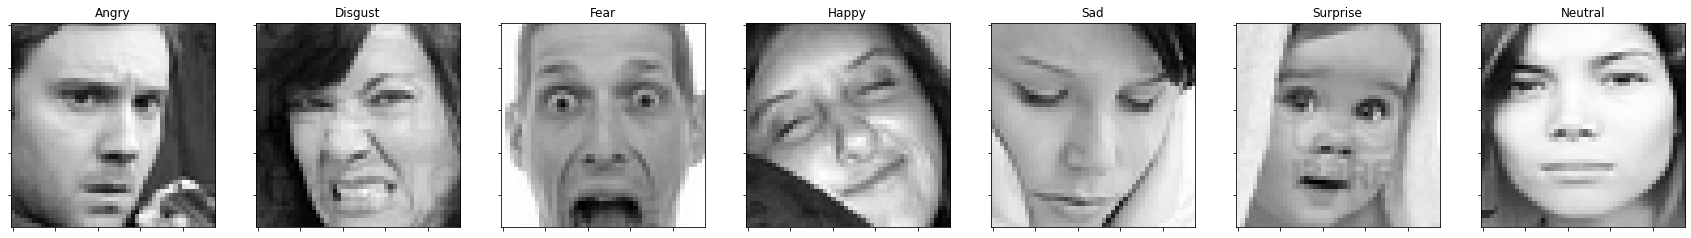

In [26]:
#@title run the code bellow for plotting some faces 

plot_all_emotions()

- distributia datelor (pe setul de antrenare si validare)

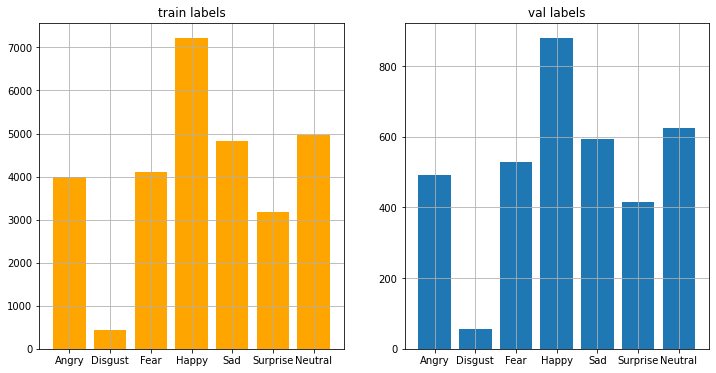

In [27]:
#@title run the code bellow for plotting the data distribution

plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

### Antrenarea unui model de predictie

- pregatirea algoritmului pentru antrenare

In [28]:
#@title run the code bellow for preparing the ML algorithm

class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))

model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 4096)              0

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


- antrenarea algoritmului

In [29]:
#@title run the code bellow for traing (please be patient!!!)
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=12,
                    batch_size=64)

Epoch 1/12
449/449 [==============================] - 73s 161ms/step - loss: 0.2687 - accuracy: 0.3147 - val_loss: 1.6134 - val_accuracy: 0.3948
Epoch 2/12
449/449 [==============================] - 71s 159ms/step - loss: 0.2278 - accuracy: 0.4354 - val_loss: 1.5016 - val_accuracy: 0.4416
Epoch 3/12
449/449 [==============================] - 71s 159ms/step - loss: 0.2061 - accuracy: 0.4888 - val_loss: 1.4025 - val_accuracy: 0.4726
Epoch 4/12
449/449 [==============================] - 71s 159ms/step - loss: 0.1937 - accuracy: 0.5220 - val_loss: 1.3423 - val_accuracy: 0.5024
Epoch 5/12
449/449 [==============================] - 71s 159ms/step - loss: 0.1840 - accuracy: 0.5478 - val_loss: 1.3188 - val_accuracy: 0.5258
Epoch 6/12
449/449 [==============================] - 76s 170ms/step - loss: 0.1750 - accuracy: 0.5688 - val_loss: 1.2587 - val_accuracy: 0.5380
Epoch 7/12
449/449 [==============================] - 73s 162ms/step - loss: 0.1673 - accuracy: 0.5879 - val_loss: 1.2503 - val_ac

### Utilizarea modelului de predictie pentru a eticheta alte imagini

In [30]:
#@title run the code bellow for predicting the emotions of new faces/images

pred_test_labels = model.predict(test_images)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)

113/113 [==============================] - 3s 27ms/step - loss: 1.3688 - accuracy: 0.5447
test caccuracy: 0.5447199940681458


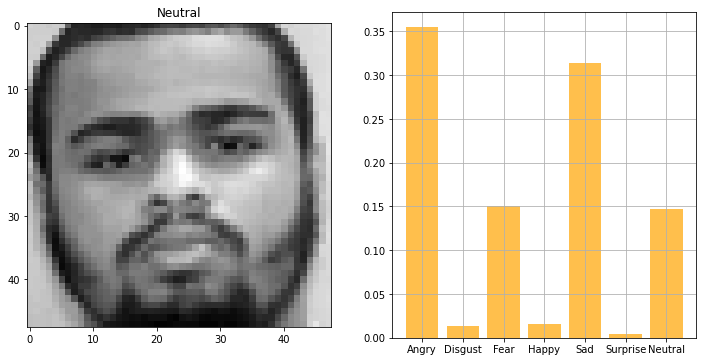

In [31]:
#@title run the code below to see one of the the predictions

plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 106)

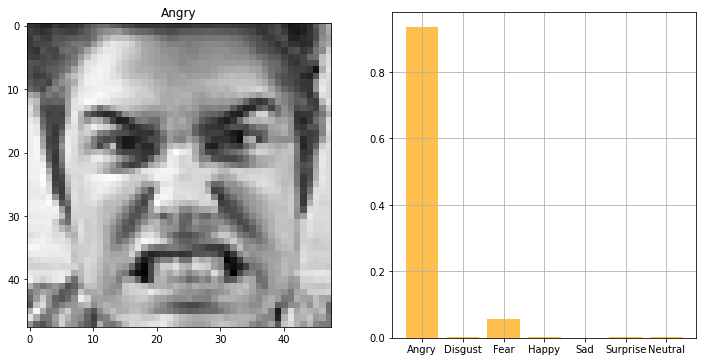

In [32]:
#@title run the code below to see another one of the the predictions

plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 40)

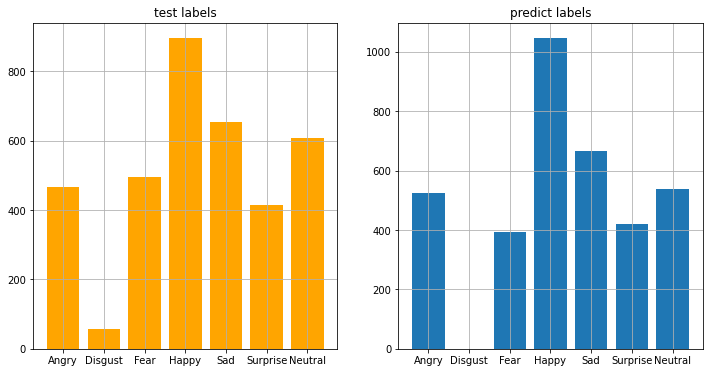

In [33]:
#@title run the code below to compare the true emotions by the predicted emotions

plot_compare_distributions(test_labels, pred_test_labels, title1='test labels', title2='predict labels')

## Scenariul 5 Separarea emailurilor in doua categorii (spam si ham)

Grupare mesaje - se doreste clasificarea unor mesaje in doua categorii (spam si ham). Pentru fiecare mesaj se cunoaste textul aferent lui.

Proces:
- Se pleaca de la un set de date format din textul mesajelor precum cel din fisierul spam.csv
- Se extrag anumite caracteristici din textul mesajelor folosind diferite reprezentari precum: Bag of Words, TF-IDF sau Word2Vec
- Se aplica algoritmul de invatare pe setul de antrenament
- Se realizeaza predictii pentru noi mesaje (= se eticheteaza noi mesaje)


### Specificarea problemei

- date de intrare: mesaje (emailuri in format text)
- date de iesire: tipul mesajelor (spam sau ham)

### Incarcarea si auditarea datelor

In [40]:
#@title run the code below for loading and auditing the data (please be patinet during the laoding)

url = 'http://www.cs.ubbcluj.ro/~lauras/test/docs/docum/spam.csv'
r = requests.get(url)
filePath = io.StringIO(r.text)

data = []
csv_reader = csv.reader(filePath, delimiter=',')
line_count = 0
for row in csv_reader:
    if line_count == 0:
        dataNames = row
    else:
        data.append(row)
    line_count += 1

inputs = [data[i][0] for i in range(len(data))]
outputs = [data[i][1] for i in range(len(data))]
labelNames = list(set(outputs))


- cateva exemple

In [41]:
#@title run the code bellow to see some examples

print('Message: [', inputs[0], '] is a', labelNames[0])
print('Message: [', inputs[1], '] is a', labelNames[1])

Message: [ Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... ] is a ham
Message: [ Ok lar... Joking wif u oni... ] is a spam


In [42]:
#@title run the code bellow for preparing data for training 

import numpy as np

np.random.seed(5)
# noSamples = inputs.shape[0]
noSamples = len(inputs)
indexes = [i for i in range(noSamples)]
trainSample = np.random.choice(indexes, int(0.8 * noSamples), replace = False)
testSample = [i for i in indexes  if not i in trainSample]

trainInputs = [inputs[i] for i in trainSample]
trainOutputs = [outputs[i] for i in trainSample]
testInputs = [inputs[i] for i in testSample]
testOutputs = [outputs[i] for i in testSample]

# representation: tf-idf features - word granularity
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=50)

trainFeatures = vectorizer.fit_transform(trainInputs)
testFeatures = vectorizer.transform(testInputs)

### Antrenarea unui model de predictie

In [37]:
#@title run the code bellow for traing (please be patient!!!)

from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
classifier.fit(trainFeatures, trainOutputs)
computedLabels = classifier.predict(testFeatures)

from sklearn.metrics import accuracy_score
print("acc: ", accuracy_score(testOutputs, computedLabels))


acc:  0.9327354260089686


### Utilizarea modelului de predictie pentru a eticheta alte mesaje

In [38]:
#@title run the code bellow for predicting the type of new messages

pred_test_labels = model.predict(test_images)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)

113/113 [==============================] - 3s 22ms/step - loss: 1.3688 - accuracy: 0.5447
test caccuracy: 0.5447199940681458


In [39]:
#@title run the code below to see several predictions 


print('Message: [', testInputs[0], '] is a', computedLabels[0])
print('Message: [', testInputs[20][:70], '] is a', computedLabels[20])



Message: [ Fine if thatåÕs the way u feel. ThatåÕs the way its gota b ] is a ham
Message: [ Todays Voda numbers ending 7548 are selected to receive a $350 award.  ] is a spam
